* A formula of search is applied to OpenAlex to extract an equivalent database
* We load the inspire papers and extract the dois from the `recid`s
* We extract of the dois from the results in OpenAlex and compare with the dois from inspire:
  * `DD`: inspire dois
  * `FF`: OpenAlex dois
  * `FF-DD`: dois only in OpenAlex: see [Status analysis](#Status-analysis): `status` values are:
     * valid arXiv dois without extra dois: with `status['status'] = 'ok'` and `published = False`
     * new valid dois with `status['status'] = 'ok'` with `status['affiliations_in_inspire'] = False`,  `status['date_range'] = 'outside'`, `status['mathching_inspire_authors']`. The first fixes missing affiliations, the second may be outside the date range, the third are not in inspire but have inspire authors
     * duplicated entries in OpenAlex with `status in ['duplicated', 'duplicated_dois']`
     * erros in OpenAlex with `status in [wrong_countries, wrong_doi]`. The first are bad affilitions, the second is not the real doi 
     * extra works that maybe are outside the scope of inspire with `status = 'not_inspire_scope'`
     * `status = 'erratum_or_arxiv_doi'` ?
    * `DD-FF`: dois inly in inspire:
     * Not found in the OpenAlex search formula because:
       * Missing or wrong affilitions in OpenAlex
       * Greater publication year that inspire cut of July 2022. In inspire the `publication_year` count as arXiv preprint year
       * topic assignation

## Results
### TOTAL:
* 11856 dois not in the INSPIREHEP-LA database →:
### In the scope of inspire
  * 8205 with `'status' == ok` but the proper doi was not captured because → :
      * 4487 in INSPIREHEP → :
          * 3553 works with missing affiliations in inspire but with LA aff in OA (inspire error)
          * 931 works with affiliations in inspire →:
              * 481 arxiv works which have not doi in inspire-hep (not published or published in journal without doi)
              * 450 published with inspire affiliations →:
                  * 377 of `year >= 2022` (not covered in the initial selection)
                  * 42 erratum dois (counts separatly in OpenAlex)
                  * 34 unknown 
          * 3 with mising authors in inspire: `None` affiliations in inspire
      * 3718 not in INSPIREHEP but with INSPIREHEP-LA authors accordinf to OpenAlex (in the scope of inspire)
  * 817 with wrong country assignation in OpenAlex
  * 513  arxiv works which are duplicated in OpenAlex to other works with doi in the INSPIREHEP-LA database
  * 200 doi works which are duplicated in OpenAlex to other works with doi in the INSPIREHEP-LA database
### Not in the scope of inspire
  * 2121 not in INSPIRE scope


affiliations_in_inspire
False    3553
True      931
None        3

In [1]:
import pandas as pd

In [2]:
results = pd.DataFrame([{'Type': 'Intersection INSPIRE-HEP-LA OpenAlex', 'Works count': 27138},
              {'Type': 'Missing affiliation in INSPIRE-HEP-LA', 'Works count':3553 },
              {'Type': 'Not in INSPIRE-HEP but with INSPIRE-HEP-LA authors', 'Works count': 3718 },
              {'Type': 'In not-LA INSPIRE-HEP but with wrong LA-affiliation in OpenAlex', 'Works count': 817},
              {'Type': "arXiv DOIs in OpenAlex which are duplicated to DOIs in 1.", 'Works count': 513 },
              {'Type': 'arXiv DOIs in OpenAlex unpublished in INSPIRE-HEP-LA', 'Works count': 481 },
              {'Type': 'Outside published range of INSPIRE-HEP-LA', 'Works count': 377 },
              {'Type': "Duplicated DOIs in OpenAlex corresponding to a work with two DOIs in INSPIRE-HEP-LA", 'Works count': 200 },
              {'Type': 'Independent erratum DOI in OpenAlex and two DOIS in INSPIRE-HEP-LA', 'Works count':42 },
              {'Type': 'Others', 'Works count': 35},
              {'Type': 'Not in the scope of INSPIRE-HEP-LA', 'Works count': 2121 }
             ])

In [3]:
results['Works count'].sum()

38995

In [4]:
TOTAL = results['Works count'].sum()
results['\%'] = results['Works count'].apply(lambda x: round(x/TOTAL*100,1))
results['index'] = [f"{x+1})" for x in results.index]
with open('results.tex','w') as f:
    f.write(results[['index', 'Type', 'Works count', '\%']].to_latex(index=False))

In [5]:
results['\%'].sum()

99.89999999999998

## Generate datasets

In [6]:
latin_america_countries = {
    "Argentina": "AR",
    "Bolivia": "BO",
    "Brazil": "BR",
    "Chile": "CL",
    "Colombia": "CO",
    "Costa Rica": "CR",
    "Cuba": "CU",
    "Dominican Republic": "DO",
    "Ecuador": "EC",
    "El Salvador": "SV",
    "Guatemala": "GT",
    "Haiti": "HT",
    "Honduras": "HN",
    "Mexico": "MX",
    "Nicaragua": "NI",
    "Panama": "PA",
    "Paraguay": "PY",
    "Peru": "PE",
    "Uruguay": "UY",
    "Venezuela": "VE"
}
#    "Puerto Rico": "PR",

In [7]:
import requests
import json
import time
import gzip

In [8]:
LA = []
next_cursor = "*"
p = 200
TOPICS = 't10048|t10224|t10527|t10921|t11090|t10025|t10095|\
t11415|t11044|t11367|t10463'

COUNTRIES = 'countries/ar|countries/bo|countries/br|countries/cl|\
countries/co|countries/cr|countries/cu|countries/do|countries/ec|\
countries/sv|countries/gt|countries/hn|countries/mx|countries/pa|\
countries/py|countries/pe|countries/uy|countries/ve'

url_topics = f"https://api.openalex.org/works?page=1&filter=topics.id:{TOPICS},\
authors_count:1-10,authorships.countries:{COUNTRIES},publication_year:1900-2022&\
sort=cited_by_count:desc&per_page={p}&cursor={next_cursor}"

In [9]:
loop = False
while loop:
    #url_topics = f"https://api.openalex.org/works?page=1&filter=authorships.author.id:a5049648126&sort=cited_by_count:desc&per_page=200&cursor={next_cursor}"
    
    j = requests.get(url_topics)
    
    la = j.json()
    
    la_meta = la.get('meta')
    next_cursor = la_meta.get('next_cursor')
    
    if not next_cursor:
        #break
        print('stop')
        break
    
    LA = LA + la.get('results')
    print(len(LA),end='\r')

In [10]:
if loop:
    with gzip.open("data/openalex_topics.json.gz", 'w') as fout:
        fout.write(json.dumps(LA).encode('utf-8'))     

In [11]:
with gzip.open("openalex_topics.json.gz", 'r') as fin:
    LA = json.loads(fin.read().decode('utf-8'))

In [95]:
if loop:
    f = 'data/papers.json'
    try:
        with open(f, 'r') as file:
            data = json.load(file)
            print("File data =", f)
    except FileNotFoundError:
        print("Error: The file 'data.json' was not found.")
    except json.JSONDecodeError:
        print("Error: Failed to decode JSON from the file.")

In [13]:
import pandas as pd

In [ ]:
if loop:
    inspa = pd.DataFrame(data)
    
    del data
    
    recids =inspa['recid'].unique()
    len(recids)
    
    recids = [int(x) for x in recids]

    del inspa<

with open('data/recids.json','w') as f:
    json.dump(recids,f)

In [97]:
with open('data/recids.json','r') as f:
    recids = json.load(f)

In [98]:
len(recids)

49181

In [18]:
393487 in recids

True

In [19]:
#list(recids).index(393487)

In [20]:
#recids = recids[32287:32288]

In [21]:
loop = False
if loop:
    dois = []
    for x in list(range(0,len(L)+1,80))[1:]:
        time.sleep(0.1)
        print(f"{x-80}:{x}",end='\r')
    
        q='%20or%20'.join([ f"recid:{x}" for x in recids[x-80:x]])
        
        url = f"https://inspirehep.net/api/literature?size=100&page=1&q={q}&fields=dois"
        
        jj = requests.get(url)
        
        try:
            LL = jj.json().get('hits').get('hits')
        except:
            LL = []
        
        if not LL:
            continue
            
        tmp = pd.DataFrame(LL)
        tmp['control_number'] = tmp['metadata'].str['control_number']
        tmp['doi'] = tmp['metadata'].str['dois'].str[0].str['value']
        dois = dois + tmp[['control_number','doi']].dropna().to_dict(orient='records')
        #break

In [22]:
if loop:
    with open("data/inspire_dois.json", "w") as json_file:
        json.dump(dois, json_file)

In [23]:
with open("data/inspire_dois.json", "r") as json_file:
    dois = json.load(json_file)

In [24]:
di = pd.DataFrame(dois)

In [25]:
di['doi'] = di['doi'].str.lower()

In [26]:
di['doi'].shape[0], di['doi'].unique().shape

(38713, (38713,))

In [27]:
df = pd.DataFrame(LA)

In [28]:
del LA

In [29]:
df.shape

(41731, 50)

In [30]:
len(df['primary_topic'].str['display_name'].unique())

274

In [31]:
topics = url_topics.split('topics.id:')[-1].split(',')[0].split('|')
topics = [t.lower() for t in topics]

In [32]:
df['topics'].apply(lambda L: [f"{d.get('display_name')} ({d.get('id').split('/')[-1].lower()})"  for d in L if d.get('id').split('/')[-1].lower() in topics] ).str[0].unique()

array(['Cosmology and Gravitation Theories (t10095)',
       'Black Holes and Theoretical Physics (t10025)',
       'Noncommutative and Quantum Gravity Theories (t11415)',
       'Particle physics theoretical and experimental studies (t10048)',
       'High-Energy Particle Collisions Research (t10527)',
       'Dark Matter and Cosmic Phenomena (t11090)',
       'Pulsars and Gravitational Waves Research (t10463)',
       'Neutrino Physics Research (t10921)',
       'Quantum Chromodynamics and Particle Interactions (t10224)',
       'Particle accelerators and beam dynamics (t11367)',
       'Particle Detector Development and Performance (t11044)'],
      dtype=object)

In [33]:
def topics_score(L,topics,score = 0):
    LL = []
    for d in L:
        if d['id'].split('/')[-1].lower() in topics and d['score'] >= score:
            LL.append(d)
    return LL

In [34]:
score = 0.9
df = df[df['topics'].apply(lambda L: topics_score(L,topics,score=score)).apply(len)> 0].reset_index(drop=True)
df.shape

(41349, 50)

In [35]:
df['doi'] = df['doi'].str.lower().str.split('https://doi.org/').str[-1]
df['doi'].shape,df['doi'].dropna().shape,df['doi'].dropna().unique().shape

((41349,), (38997,), (38995,))

In [36]:
df['countries'] = df['authorships'].apply(lambda L: [d.get('countries') for d in L]
                       ).apply(lambda L: 
        list(set([item for sublist in L for item in sublist])))


In [37]:
CC = []
for country in latin_america_countries:
    country_code = latin_america_countries[country]
    d = { 'country': country,
        'country_code': country_code, 
        'cited_by_count':int(df[df['countries'].apply(
            lambda L: country_code in L)]['cited_by_count'].sum())}
    CC.append(d)

In [38]:
%matplotlib inline

In [39]:
import matplotlib.pyplot as plt

In [40]:
with open('all_citations_total_oa.json','w') as f:
    json.dump(CC,f)

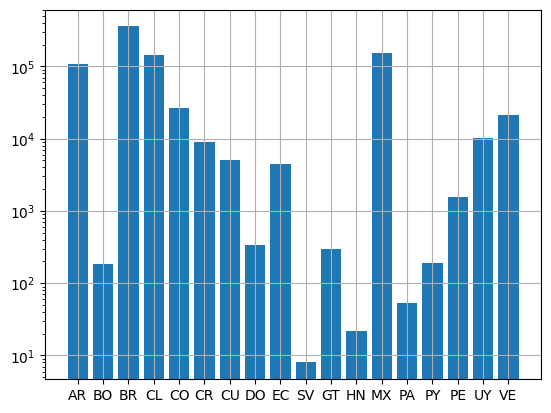

In [41]:
plt.bar([d.get('country_code') for d in CC if d.get('cited_by_count') > 0],
          [d.get('cited_by_count') for d in CC if d.get('cited_by_count') > 0])
plt.semilogy()
plt.grid()
plt.savefig('citation_count_by_OA.pdf')

In [42]:
DD = di['doi'].dropna().to_list() # dois in inspire (missing dois if duplicates)
FF = df['doi'].dropna().to_list() # dois in OpenAlex

In [43]:
'10.1016/j.nuclphysb.2018.12.017' in DD

False

In [44]:
len(DD)

38713

In [45]:
len(FF)

38997

In [46]:
intersection = list(set(DD).intersection( FF ))
len(intersection) # In both inspire and OpenAlex

27138

In [47]:
dfa = df[df['doi'].apply(lambda d: d in intersection)].reset_index(drop=True)
authors = dfa['authorships'].apply(lambda L: [d.get('author').get('id').split('/')[-1] for d in L] )
authors = list(set([item for sublist in authors for item in sublist]))
len(authors) #authors both in inspire and OpenAlex

15527

In [48]:
DDD = list(set(DD).difference( FF  ))
FFF = list(set(FF).difference(DD))

In [49]:
len(DDD) # only inspire

11575

In [50]:
with open('DDD.json','w') as f:
    json.dump(DDD,f)

In [51]:
len(FFF) # only OpenAlex

11857

In [52]:
df[df['doi'].astype(str).str.contains('arxiv')].shape # OpenAlex works in arXiv only 

(1277, 51)

In [53]:
trueFF = df[df['primary_location'].str['source'].str['issn_l'].apply(lambda s: s is not None)]['doi'].dropna().to_list()

In [54]:
len(trueFF),len(FF)

(35136, 38997)

In [55]:
trueFFF = list(set(trueFF).difference(DD))

In [56]:
len(trueFFF)

8941

In [57]:
del df

In [58]:
del dfa

In [59]:
def get_inspire(url):
    jj = requests.get(url)
        
    try:
        LL = jj.json().get('hits').get('hits')
    except:
        LL = []

    return LL
    
def clean_dois(dois):
    return [d for d in dois if d.get('source') != 'arXiv' and d.get('material') != 'erratum']



def get_authors(doi,authors):
    status = {}
    url = f"https://api.openalex.org/works?filter=doi:{doi}"
    jj = requests.get(url)
    time.sleep(0.1)
    if jj.status_code == 200 and jj.json().get('meta') and jj.json().get('meta').get('count'):
        try:
            au = [ d.get('author').get('id').split('/')[-1] for d in jj.json().get('results')[0].get('authorships')]
        except:
            au = []
        auint = list(set(au).intersection(authors))    
        if len(auint) > 0:
            status = { 'status': 'ok',
                       'mathching_inspire_authors': True,
                       'mathching_inspire_author_ids': auint,
                       'doi': doi}
        else: # outside inspire
            status = { 'status': 'not_inspire_scope', 
                       'mathching_inspire_authors': False,
                       'mathching_inspire_author_ids': [],
                       'doi': doi}
    return status

In [60]:
no_issn_dois = list(set(FFF).difference(trueFFF)) # doi not relate to journals with issns
no_issn_dois[0:15]

['10.1007/978-3-662-46035-1_11',
 '10.26512/2015.08.d.18709',
 '10.48550/arxiv.0810.1071',
 '10.48550/arxiv.astro-ph/0210583',
 '10.1142/9789812704030_0298',
 '10.1142/9789812702227_0107',
 '10.48550/arxiv.0801.2559',
 '10.1007/978-3-319-21846-5_124',
 '10.48550/arxiv.1710.10929',
 '10.1142/9789812811653_0011',
 '10.48550/arxiv.1708.04718',
 '10.48550/arxiv.2006.07290',
 '10.1142/9789814447232_0002',
 '10.48550/arxiv.2101.02753',
 '10.24275/uami.br86b365p']

## Status analysis

In [61]:
2151035 not in recids

True

In [62]:
def get_year(arxiv_doi):
    arxiv_id =arxiv_doi.split('/')
    if len(arxiv_id) == 2:
        year = eval('20'+arxiv_id[-1].split('arxiv.')[-1][:2])
    elif len(arxiv_id) == 3:
        year = arxiv_id[-1][:2]
        if year[0] == '0':
             year = eval('20' + year)
        else:
            year = eval('19' + year)
    
    return year

In [63]:
max_year = 2022
arxiv_doi = '10.48550/arxiv.0801.2559'
arxiv_doi = '10.48550/arxiv.astro-ph/9505300'
arxiv_doi = '10.48550/arxiv.astro-ph/0505300'
get_year(arxiv_doi)

2005

In [64]:
doi = '10.1088/1742-6596/590/1/012008'
doi =  '10.48550/arxiv.0801.2559'
#doi = '10.1103/physrevd.93.124020'
#doi = '10.48550/arxiv.astro-ph/0505300' # test: not_doi
#doi = '10.48550/arxiv.1909.10299' # test: duplicated
#doi = '10.1007/s100520050258' # test: duplicated_dois
#doi = '10.1140/epjc/s10052-015-3288-x' # test: right_countries
#doi = '10.1007/bf02817915' # test: wrong_countries
doi = '10.24275/uami.gq67jr29s' # test: 'mathching_inspire_authors' and 'status': 'not_inspire_scope'
doi = '10.1016/0003-4916(82)90173-7' # test matching_authors
doi = '10.1063/1.2710571' # test wrong_affiliations
doi = '10.1016/0550-3213(95)00620-6' # test duplicated dois
#doi = '10.1088/1742-6596/590/1/012008' #test
#doi = '10.1140/epjc/s10052-022-11127-w' # test outside_range
#doi = '10.1007/bf00762333' # test 'mathching_inspire_authors'

In [65]:
def check_doi(doi, recids, DD, authors, max_year):
    url = f"https://inspirehep.net/api/literature?q=doi:{doi}&fields=control_number,authors,dois,publication_info"
    LL = get_inspire(url)
    time.sleep(0.1)

    
    status = {'doi':doi,'in_inspire': False}
    arxiv_doi = None
    if doi.find('/arxiv.') == 8:
        arxiv_doi = doi
    
    status['arxiv_doi'] = arxiv_doi
    
    metadata = None
    if LL:
        metadata = LL[0].get('metadata')
        status['in_inspire'] = True # len(LL) != 0
    inspire_authors = None
    all_dois = None
    control_number = None
    publication_info = None
    if metadata:
        inspire_authors = metadata.get('authors')
        all_dois = metadata.get('dois')
        control_number = metadata.get('control_number')
        publication_info = metadata.get('publication_info')
    
    inspire_dois = []
    status['recid'] = control_number
    status['in_recids'] = False
    status['published'] = True
    status['erratum_doi'] = None
    status['inspire_dois'] = []
    status['new_doi'] = None
    status['oa_errors'] = []
    status['inspire_scope'] = True
    status['new_doi_in_inspire'] = None
    status['affiliations_in_inspire'] = None
    status['mathching_inspire_authors'] = None
    status['mathching_inspire_author_ids'] = None
    status['date_range'] = None
    status['year'] = None
    
    if publication_info:
        try:
            status['year'] = max([d.get('year') for d in publication_info])
        except:
            status['year'] = None
    
    if not status['year'] and status['arxiv_doi']:
        status['year'] = get_year(status['arxiv_doi'])
    
    # chek if already in database
    if control_number and control_number in recids:
        status['in_recids'] = True
    else:
        # check inspire_scope
        pass
    
    # Check if published with doi
    if all_dois:
        erratum_doi = [d for d in all_dois if d.get('material') == 'erratum']
        if erratum_doi:
            status['erratum_doi'] = erratum_doi[0]
        inspire_dois = [d for d in all_dois if d.get('source') != 'arXiv' and d.get('material') != 'erratum']
        status['inspire_dois'] = list(set([d.get('value').lower() for d in inspire_dois]))
    else:
        if status['in_inspire']:
            status['published'] = False
    
    # Analysis
    status['status'] = None
    if status.get('arxiv_doi') and status['inspire_dois']:
        status['new_doi'] = status['inspire_dois'][0]
        status['status'] = 'duplicated'
        status['oa_errors'].append(status['status'])
    else:
        status['status'] = 'ok'
    
    if not status.get('arxiv_doi') and status['inspire_dois']:
        if len(status['inspire_dois']) > 1:
            status['new_doi'] = [x for x in status['inspire_dois'] if x != doi ][0]
            status['status'] = 'duplicated_dois'
            status['oa_errors'].append(status['status'])
    else:
        if not status['oa_errors']:
            status['status'] = 'ok'
    
    if status['new_doi'] and status['new_doi'] in DD:
        status['new_doi_in_inspire'] = True
    else:
        status['new_doi_in_inspire'] = False
    if inspire_authors:
        affiliations = [d for d in inspire_authors if d.get('affiliations')]
        if affiliations: # not affiliations in inspire
            status['affiliations_in_inspire'] = True
        else:
            status['affiliations_in_inspire'] = False
    
    # not in inspire LA database but in inspire → affiliations exist and are not LA
    if status['in_inspire'] and not status['in_recids'] and status['affiliations_in_inspire']:
        # check year conflict
        if status['year'] and status['year'] >= max_year:
            status['status'] = 'ok'
            status['date_range'] = 'outside'
        else:
            status['status'] = 'wrong_countries'
            status['oa_errors'].append(status['status'])
    else:
        if not status['oa_errors']:
            status['status'] = 'ok'
    
    # not in inspire → check for inspire authors
    if not status['in_inspire'] and not status['in_recids']:
        check_status = get_authors(doi,authors)
        status['status'] = check_status['status']
        if status['status'] == 'not_inspire_scope':
            status['oa_errors'].append(status['status'])
        else:
            if not status['oa_errors']:
                status['status'] = 'ok'
            
        status['mathching_inspire_authors'] = check_status['mathching_inspire_authors']
        status['mathching_inspire_author_ids'] = check_status['mathching_inspire_author_ids']
    
    if len(status.get('oa_errors')) > 0:
        status['status'] = status.get('oa_errors')[0]
    return status

In [78]:
#status

In [79]:
#dfa[dfa['authorships'].apply(lambda L: [d.get('author').get('id').split('/')[-1] for d in L] ).apply(lambda L: 'A5058759801' in L)]

In [123]:
#check_doi(doi,recids, DD, authors, max_year)

### Only OpenAlex

In [66]:
if loop:
    ST = []
    i = 0
    for doi in FFF:
        status = {}
        i += 1
        print(str(i).zfill(5),end='\r',flush=True)
        status = check_doi(doi,recids, DD, authors, max_year)
        ST.append(status)

In [67]:
if loop:
    with open('data/only_openalex.json','w') as f:
        json.dump(ST,f)

In [68]:
with open('data/only_openalex.json','r') as f:
    ST = json.load(f)

In [69]:
len(FFF)

11857

In [70]:
import pandas as pd

In [71]:
ST = pd.DataFrame(ST)

In [72]:
len(DDD)

11575

In [73]:
def fix_status_ok(oa_errors,status):
    if len(oa_errors) > 0:
        status = oa_errors[0]
    return status

In [74]:
ST['status'] = ST.apply(lambda d: fix_status_ok(d['oa_errors'],d['status']), axis='columns')

In [75]:
ST[ST['oa_errors'].apply(len)>0]['status'].value_counts()#.sum()

status
not_inspire_scope    2121
wrong_countries       817
duplicated            513
duplicated_dois       200
Name: count, dtype: int64

In [76]:
ST['status'].value_counts()

status
ok                   8204
not_inspire_scope    2121
wrong_countries       817
duplicated            513
duplicated_dois       200
Name: count, dtype: int64

In [77]:
ST['status'].value_counts().sum()

11855

In [78]:
ok = ST[ST['status'] == 'ok']
ok.shape

(8204, 18)

In [79]:
in_inspire = ok[ok['in_inspire']]
in_inspire.shape

(4486, 18)

In [80]:
not_in_inspire = ok[~ok['in_inspire']]
not_in_inspire.shape

(3718, 18)

In [81]:
in_inspire['affiliations_in_inspire'].fillna('None').value_counts()

affiliations_in_inspire
False    3553
True      930
None        3
Name: count, dtype: int64

In [82]:
in_inspire['affiliations_in_inspire'].fillna('None').value_counts().sum()

4486

In [83]:
not_aff = in_inspire[~in_inspire['affiliations_in_inspire'].fillna(True)].reset_index(drop=True)
not_aff.shape[0]

3553

In [84]:
not_aff['doi'].iloc[0]

'10.1142/s0218271810017950'

In [85]:
in_inspire_aff = in_inspire[in_inspire['affiliations_in_inspire'] == True].reset_index(drop=True)
in_inspire_aff.shape[0]

930

In [86]:
None_aff = in_inspire[in_inspire['affiliations_in_inspire'].isna()]
None_aff.shape

(3, 18)

In [87]:
None_aff

,doi,in_inspire,arxiv_doi,recid,in_recids,published,erratum_doi,inspire_dois,new_doi,oa_errors,inspire_scope,new_doi_in_inspire,affiliations_in_inspire,mathching_inspire_authors,mathching_inspire_author_ids,date_range,year,status
288,10.1109/23.34546,True,None,277148.0,False,True,None,[10.1109/23.34546],None,[],True,False,None,None,None,None,1989.0,ok
3043,10.1088/1742-6596/354/1/012015,True,None,1112635.0,False,True,None,[10.1088/1742-6596/354/1/012015],None,[],True,False,None,None,None,None,NaN,ok
6457,10.14311/app.2014.01.0132,True,None,1421731.0,False,True,None,[10.14311/app.2014.01.0132],None,[],True,False,None,None,None,None,2014.0,ok


In [335]:
not_published = in_inspire_aff[( (in_inspire_aff['arxiv_doi'].str.contains('arxiv\.'))  
               & (~in_inspire_aff['published']) )]

not_published.shape[0],

(481,)

In [336]:
published = in_inspire_aff[~( (in_inspire_aff['arxiv_doi'].str.contains('arxiv\.'))  
               & (~in_inspire_aff['published']) )]

published.shape[0],

(450,)

In [339]:
published_year = published[published['year']>=2022]
published_year.shape

(377, 19)

In [340]:
published_year['doi'].drop_duplicates().shape

(376,)

In [342]:
published_not_year = published_ok[published_ok['year'].fillna(0)<2022]
published_not_year.shape

(76, 19)

In [343]:
published_not_year[published_not_year['erratum_doi'].apply(lambda d: isinstance(d,dict))].shape[0]

42

In [344]:
published_not_year[~published_not_year['erratum_doi'].apply(lambda d: isinstance(d,dict))].shape

(34, 19)

### Only INSPIRE-HEP

In [136]:
DDD[:10]

['10.1103/physrevd.30.765',
 '10.1088/1742-6596/410/1/012073',
 '10.1063/1.54697',
 '10.1017/s1743921306003127',
 '10.1140/epjc/s10052-019-7461-5',
 '10.1103/physrevd.66.045004',
 '10.1016/j.physletb.2005.08.095',
 '10.1086/426809',
 '10.2991/jnmp.2003.10.2.7',
 '10.1007/jhep10(2015)191']

In [138]:
if loop:
    OA = []
    i = 0
    for t in DDD:
        url = f"https://api.openalex.org/works?filter=doi:{t}"
        j = requests.get(url)
        try:
            jj = j.json().get('results')[0]
        except:
            pass
        if jj:
            OA.append(jj)
        print(str(i).zfill(5),end='\r')
        i += 1
        time.sleep(0.1)

In [162]:
len(DD)

38713

In [114]:
if loop:
    with gzip.open('data/only_inspire_in_OpenAlex.json.gz','w') as f:
        f.write(json.dumps(OA).encode('utf-8')) 

In [115]:
with gzip.open('data/only_inspire_in_OpenAlex.json.gz','r') as f:
        OA = json.loads(f.read().decode('utf-8'))

In [117]:
len(OA)

11575

In [143]:
OA = pd.DataFrame(OA)

In [144]:
OA.shape

(11575, 51)

In [145]:
OA['doi'] = OA['doi'].str.lower().str.split('https://doi.org/').str[-1]

In [146]:
OA[OA['topics'].apply(len)==0].reset_index(drop=True).shape

(93, 51)

In [154]:
OA[OA['authorships'].apply(len) == 0].shape #Not authors at all

(28, 52)

In [158]:
OA[OA['countries_distinct_count'] == 0].shape

(1175, 52)

In [157]:
OALA = OA[OA['countries_distinct_count'] != 0]
OALA.shape

(10400, 52)

In [147]:
OA[OA['publication_year']>2022].shape

(274, 51)

In [232]:
#OA['primary_topic'].str['display_name'].value_counts()[:30]

In [148]:
OA['filtered_topics'] = OA['topics'].apply(lambda L: topics_score(L,topics,score=0.9))
OA[OA['filtered_topics'].apply(len)>0].shape

(2169, 52)

In [149]:
OA.columns

Index(['id', 'doi', 'title', 'display_name', 'publication_year',
       'publication_date', 'ids', 'language', 'primary_location', 'type',
       'type_crossref', 'indexed_in', 'open_access', 'authorships',
       'institution_assertions', 'countries_distinct_count',
       'institutions_distinct_count', 'corresponding_author_ids',
       'corresponding_institution_ids', 'apc_list', 'apc_paid', 'fwci',
       'has_fulltext', 'cited_by_count', 'citation_normalized_percentile',
       'cited_by_percentile_year', 'biblio', 'is_retracted', 'is_paratext',
       'primary_topic', 'topics', 'keywords', 'concepts', 'mesh',
       'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'datasets', 'versions',
       'referenced_works_count', 'referenced_works', 'related_works',
       'abstract_inverted_index', 'cited_by_api_url', 'counts_by_year',
       'updated_date', 'created_date', 'fulltext_origin',
       'is_authors_truncated', 'filtered_top

In [234]:
OAT =  OA[OA['filtered_topics'].apply(len)==0].reset_index(drop=True)

In [235]:
NOAT = OAT[OAT['authorships'].apply(lambda L: list(set(authors).intersection( [d.get('author').get('id').split('/')[-1] for d in L] ))).apply(len) == 0]

In [262]:
NOAT.shape

(2149, 52)

In [263]:
7257+2149

9406

In [236]:
NOAT.sample()['doi']

3213    10.1016/j.nuclphysb.2007.09.011
Name: doi, dtype: object

In [237]:
NOAT['primary_topic'].str['display_name'].value_counts()[:50]

primary_topic
Stellar, planetary, and galactic studies             393
Galaxies: Formation, Evolution, Phenomena            272
Astrophysics and Star Formation Studies              246
Quantum Information and Cryptography                  62
Quantum Mechanics and Applications                    55
Quantum Computing Algorithms and Architecture         47
Advanced Thermodynamics and Statistical Mechanics     47
Theoretical and Computational Physics                 45
Cold Atom Physics and Bose-Einstein Condensates       33
Astrophysics and Cosmic Phenomena                     32
Quantum many-body systems                             32
Quantum Mechanics and Non-Hermitian Physics           32
Solar and Space Plasma Dynamics                       32
Astrophysical Phenomena and Observations              31
Quantum chaos and dynamical systems                   30
Astronomy and Astrophysical Research                  28
Quantum and electron transport phenomena              27
Astro and Planeta

In [168]:
bad_affs = OALA[OALA['authorships'].apply(lambda L: [d.get('countries') for d in L]).apply(
    lambda L: [item for sublist in L for item in sublist]).apply(
    lambda L: list(set(latin_america_countries.values()).intersection(L))
   ).apply(len)==0]
bad_affs.shape

(1635, 52)

38713

In [170]:
bad_affs.shape[0]/len(DD)*100

4.223387492573554

In [167]:
bad_affs['doi'].sample()

5617    10.1088/1361-6382/ab4974
Name: doi, dtype: object

In [204]:
OA[OA['authorships'].apply(lambda L: [d.get('countries') for d in L]).apply(
    lambda L: [item for sublist in L for item in sublist]).apply(
    lambda L: list(set(latin_america_countries.values()).intersection(L))
   ).apply(len)==0].shape

(2810, 52)

In [160]:
2810-1635

1175

In [161]:
len(DD)

38713

In [207]:
OA[OA['authorships'].apply(len)>10].shape

(19, 52)

In [156]:
OA[OA['authorships'].apply(lambda L: [d.get('countries') for d in L]).apply(
    lambda L: [item for sublist in L for item in sublist]).apply(
    lambda L: list(set(latin_america_countries.values()).intersection(L))
   ).apply(len)==0].shape

(2810, 52)

In [184]:
kk = OAC[OAC['authorships'].apply(lambda L: [d.get('countries') for d in L]).apply(
    lambda L: [item for sublist in L for item in sublist]).apply(
    lambda L: list(set(latin_america_countries.values()).intersection(L))
   ).apply(len)>0]
kk[kk['publication_year'] < 2022]['doi']

3673     https://doi.org/10.1016/s0370-2693(02)02102-0
4331               https://doi.org/10.22323/1.395.0855
5541                 https://doi.org/10.1063/1.3399360
7912                 https://doi.org/10.1063/1.3448000
8071                 https://doi.org/10.1063/1.3622713
9533                 https://doi.org/10.1063/1.3455972
10745        https://doi.org/10.1007/s10686-015-9470-1
10788                https://doi.org/10.1063/1.2813786
Name: doi, dtype: object

In [238]:
doi = '10.1016/s0370-2693(02)02102-0'


In [248]:
def get_inspire_categories(doi):
    url = f"https://inspirehep.net/api/literature?q=doi:{doi}&fields=inspire_categories"
    LL = requests.get(url)
    time.sleep(0.1)
    if (LL.status_code == 200 
     and LL.json().get('hits') 
     and LL.json().get('hits').get('hits') 
     and LL.json().get('hits').get('hits')[0].get('metadata')):
        return LL.json().get('hits').get('hits')[0].get('metadata').get('inspire_categories')

In [252]:
NOAT['doi']

14         10.1051/0004-6361:20077923
16                     10.1086/428400
20                     10.1086/379921
23          10.1017/s1743921306003309
25           10.1088/1751-8121/ac6718
                    ...              
9384      10.1109/escience.2018.00081
9391      10.1088/0305-4470/39/21/s70
9392    10.1016/s0217-7323(00)00052-9
9400    10.1016/s0217-7323(00)00031-1
9404                   10.1086/522927
Name: doi, Length: 2149, dtype: object

In [256]:
IC = []
i=0
for doi in NOAT['doi']:
    i += 1
    print(str(i).zfill(4), end = '\r', flush=True)
    IC.append({'doi':'doi',
               'inspire_categories': get_inspire_categories(doi)
              })

In [260]:
pd.DataFrame(IC)['inspire_categories'].str[0].str['term'].value_counts()

inspire_categories
Astrophysics                    1147
General Physics                  216
Quantum Physics                  200
Math and Math Physics            105
Theory-HEP                        79
Condensed Matter                  39
Phenomenology-HEP                 32
Theory-Nucl                       31
Gravitation and Cosmology         27
Instrumentation                   24
Computing                         24
Experiment-HEP                    22
Other                             20
Accelerators                      17
Experiment-Nucl                   13
Lattice                            6
Data Analysis and Statistics       3
Name: count, dtype: int64

In [261]:
NOAT['primary_topic'].str['display_name'].value_counts()[:10]

primary_topic
Stellar, planetary, and galactic studies             393
Galaxies: Formation, Evolution, Phenomena            272
Astrophysics and Star Formation Studies              246
Quantum Information and Cryptography                  62
Quantum Mechanics and Applications                    55
Quantum Computing Algorithms and Architecture         47
Advanced Thermodynamics and Statistical Mechanics     47
Theoretical and Computational Physics                 45
Cold Atom Physics and Bose-Einstein Condensates       33
Astrophysics and Cosmic Phenomena                     32
Name: count, dtype: int64

### Check results